In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from astropy.io import fits
pandarallel.initialize(progress_bar=True)
import random
from numpy.random import default_rng
import numpy as np
rng = default_rng(42)
import shutil
import glob
from scipy import ndimage


INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [45]:
path = '/data/processing/avera/proyecto_deep/'
df = pd.read_csv("Detecciones2.csv") # Z=0
#df = pd.read_csv("zvar2.csv")

/tmp/ipykernel_13015/1600711948.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['AU'][df_final['AU'].str.split("_").str[3]=="rot0"]= df_final['AU'][df_final['AU'].str.split("_").str[3]=="rot0"].str[:]+"0"
/tmp/ipykernel_13015/1600711948.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['AU'][df_final['AU'].str.split("_").str[3]=="rot0"]= df_final['AU'][df_final['AU'].str.split("_").str[3]=="rot0"].str[:]+"0"


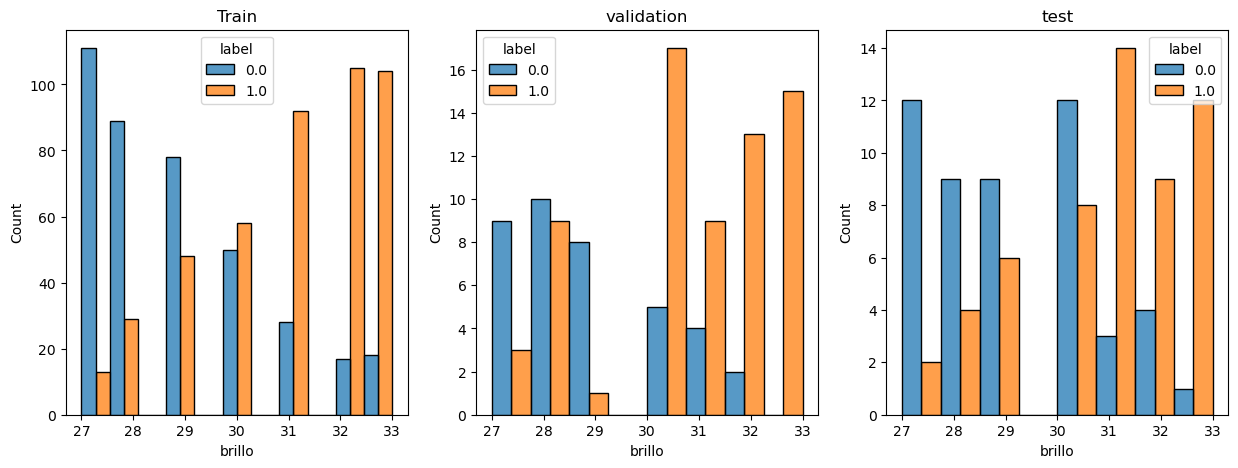

In [46]:
### PARA Z=0
df_final = pd.DataFrame({"AU":[] ,"label":[],"brillo":[] })
for i in range(27,34):
    i = str(i)
    df_variable=pd.DataFrame({"AU":df['AU'].str.split("_").str[0]+"_snap127"+"_SB"+i+"_rot"+df['AU'].str.split("_").str[1]})
    df_variable["label"] = df[i]
    df_variable["brillo"] = int(i)
    df_final = pd.concat([df_final,df_variable[["AU","label","brillo"]]])

df_final['AU'][df_final['AU'].str.split("_").str[3]=="rot0"]= df_final['AU'][df_final['AU'].str.split("_").str[3]=="rot0"].str[:]+"0"    

    
df_final = df_final.reset_index(drop=True)
#df_final["brillo"] = df_final["AU"].str.split("_SB").str[-1]
#df_final["brillo"] = df_final["brillo"].astype(float)

df_final.loc[df_final.sample(frac=0.1,weights='brillo',random_state=2).index,"subgrup"] = "test"
mask1 = df_final.loc[df_final["subgrup"]!="test"].sample(frac=0.111,weights='brillo',random_state=9).index
df_final.loc[mask1,"subgrup"] = "val"
df_final.loc[df_final["subgrup"].isna(),"subgrup"] = "train"

fig,ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(ax=ax[0],data=df_final.loc[df_final["subgrup"]=="train"],x="brillo",hue="label", multiple="dodge")
sns.histplot(ax=ax[1],data=df_final.loc[df_final["subgrup"]=="val"],x="brillo",hue="label", multiple="dodge")
sns.histplot(ax=ax[2],data=df_final.loc[df_final["subgrup"]=="test"],x="brillo",hue="label", multiple="dodge")
ax[0].set_title('Train')
ax[1].set_title('validation')
ax[2].set_title('test')
fig.show()



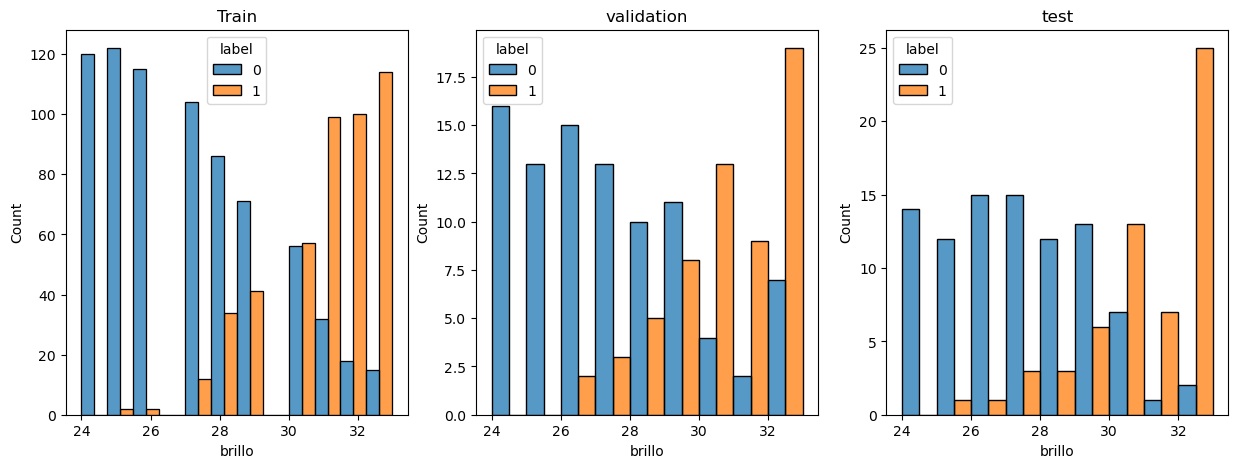

In [4]:
### PARA ZVAR

df_final = pd.DataFrame({})
for i in range(24,34):
    i = str(i)
    df_variable = df[["AU"]] +"_SB"+i
    df_variable["label"] = df[i]
    df_final = pd.concat([df_final,df_variable])

df_final = df_final.reset_index(drop=True)
df_final["brillo"] = df_final["AU"].str.split("_SB").str[-1]
df_final["brillo"] = df_final["brillo"].astype(float)

df_final.loc[df_final.sample(frac=0.1,weights='brillo',random_state=2).index,"subgrup"] = "test"
mask1 = df_final.loc[df_final["subgrup"]!="test"].sample(frac=0.111,weights='brillo',random_state=2).index
df_final.loc[mask1,"subgrup"] = "val"
df_final.loc[df_final["subgrup"].isna(),"subgrup"] = "train"

fig,ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(ax=ax[0],data=df_final.loc[df_final["subgrup"]=="train"],x="brillo",hue="label", multiple="dodge")
sns.histplot(ax=ax[1],data=df_final.loc[df_final["subgrup"]=="val"],x="brillo",hue="label", multiple="dodge")
sns.histplot(ax=ax[2],data=df_final.loc[df_final["subgrup"]=="test"],x="brillo",hue="label", multiple="dodge")
ax[0].set_title('Train')
ax[1].set_title('validation')
ax[2].set_title('test')
fig.show()



In [47]:
def abrir_fits(ruta):
    hdu_list = fits.open(ruta,memmap=False)
    image_data = hdu_list[0].data
    hdu_list.close()
    return image_data

In [48]:
def data_augmentation(path_plots,nomb,img,rng,tipo,numero):
    '''
    Función que genera una imagen fits con rotación al azar entre 0 y 360
    El rng permite que no se repitan las rotaciones
    hay un choice para seleccionar flip en el eje x, y o ambos
    '''

    angulo_de_rotacion = rng.choice(360, size=1, replace=False)[0]
    img_rotate = ndimage.rotate(img,angulo_de_rotacion, reshape=False,mode='reflect',order=1)
    flip_x = np.fliplr(img_rotate)
    flip_y = np.flipud(img_rotate)
    flip_xy = np.flipud(np.fliplr(img_rotate))
    mylist = [flip_x,flip_y,flip_xy]
    random_image = random.choice(mylist)
    plt.imshow(random_image, cmap=plt.cm.brg)
    hdu = fits.PrimaryHDU(random_image)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(f'{path_plots}{tipo}/{numero}_{nomb}.fits',overwrite=True)
    return

In [49]:
train = df_final.loc[df_final["subgrup"]=="train"].reset_index(drop=True)
val = df_final.loc[df_final["subgrup"]=="val"].reset_index(drop=True)
test = df_final.loc[df_final["subgrup"]=="test"].reset_index(drop=True)

path = "/data/processing/avera/proyecto_deep/"
#path = "/data/processing/avera/proyecto_deep/zvar_dat_aug/"

train.to_csv(f"{path}Z0train.csv",index=False)
val.to_csv(f"{path}Z0val.csv",index=False)
test.to_csv(f"{path}Z0test.csv",index=False)

In [50]:
train["image"] = train.apply(lambda row : abrir_fits(f"{path}fits_rot/"+ row["AU"]+".fits"), axis=1)

In [51]:
numero_training = train.groupby(["brillo","label"]).count()["AU"].max()
numero_training

111

In [52]:
path = "/data/processing/avera/proyecto_deep/z0_da"
training_df = train.loc[train["label"]==1].reset_index(drop=True)
training_df['label']  = training_df['label'].apply(int)
grouped = training_df.groupby(training_df["brillo"])

for tipos in training_df["brillo"].unique() :
    print(tipos)
    
    training = grouped.get_group(tipos)
    if numero_training == len(training):
        continue
    if numero_training/len(training) < 2:
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path}/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
    else : 
        numero_entero = int(numero_training/len(training))
        if numero_training-len(training)*numero_entero != 0 :
            training.head(numero_training-len(training)*numero_entero).parallel_apply(lambda row : data_augmentation(f"{path}/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
        rng = default_rng(42)
        for i in range(numero_entero-1):
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path}/",row["AU"],row["image"],rng,row["label"],i),axis=1,result_type="expand")
    

27.0


28.0


29.0


30.0


31.0


32.0


33.0


In [53]:
path = "/data/processing/avera/proyecto_deep/z0_da"
training_df = train.loc[train["label"]==0].reset_index(drop=True)
training_df['label']  = training_df['label'].apply(int)
grouped = training_df.groupby(training_df["brillo"])

for tipos in training_df["brillo"].unique() :
    print(tipos)
    
    training = grouped.get_group(tipos)
    if numero_training == len(training):
        continue
    if numero_training/len(training) < 2:
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path}/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
    else : 
        numero_entero = int(numero_training/len(training))
        if numero_training-len(training)*numero_entero != 0 :
            training.head(numero_training-len(training)*numero_entero).parallel_apply(lambda row : data_augmentation(f"{path}/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
        rng = default_rng(42)
        for i in range(numero_entero-1):
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path}/",row["AU"],row["image"],rng,row["label"],i),axis=1,result_type="expand")
    

27.0
28.0


29.0


30.0


31.0


32.0


33.0


In [54]:
path = "/data/processing/avera/proyecto_deep/"

train.loc[train["label"]==0].parallel_apply(lambda row : shutil.copy(f"{path}fits_rot/" + row["AU"] +".fits",f"{path}z0_da/"),axis=1,result_type="expand")


0      /data/processing/avera/proyecto_deep/z0_da/AU1...
1      /data/processing/avera/proyecto_deep/z0_da/AU1...
2      /data/processing/avera/proyecto_deep/z0_da/AU1...
3      /data/processing/avera/proyecto_deep/z0_da/AU1...
5      /data/processing/avera/proyecto_deep/z0_da/AU2...
                             ...                        
786    /data/processing/avera/proyecto_deep/z0_da/AU1...
787    /data/processing/avera/proyecto_deep/z0_da/AU1...
788    /data/processing/avera/proyecto_deep/z0_da/AU1...
789    /data/processing/avera/proyecto_deep/z0_da/AU1...
790    /data/processing/avera/proyecto_deep/z0_da/AU1...
Length: 391, dtype: object

In [55]:

train.loc[train["label"]==1].parallel_apply(lambda row : shutil.copy(f"{path}/fits_rot/" + row["AU"] +".fits",f"{path}/z0_da/"),axis=1,result_type="expand")


4      /data/processing/avera/proyecto_deep//z0_da/AU...
47     /data/processing/avera/proyecto_deep//z0_da/AU...
49     /data/processing/avera/proyecto_deep//z0_da/AU...
50     /data/processing/avera/proyecto_deep//z0_da/AU...
51     /data/processing/avera/proyecto_deep//z0_da/AU...
                             ...                        
835    /data/processing/avera/proyecto_deep//z0_da/AU...
836    /data/processing/avera/proyecto_deep//z0_da/AU...
837    /data/processing/avera/proyecto_deep//z0_da/AU...
838    /data/processing/avera/proyecto_deep//z0_da/AU...
839    /data/processing/avera/proyecto_deep//z0_da/AU...
Length: 449, dtype: object

<Axes: xlabel='SB', ylabel='Count'>

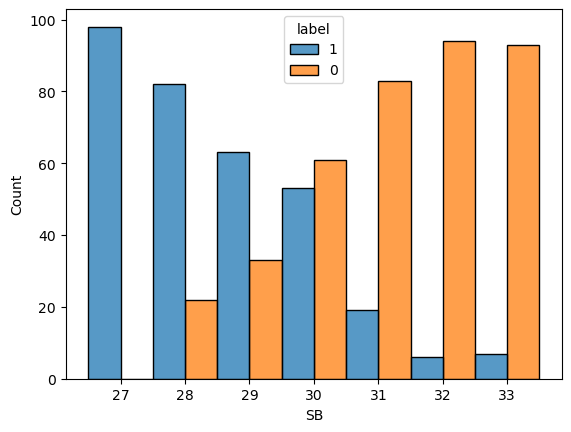

In [61]:
train = pd.concat([pd.DataFrame(glob.glob(f"{path}z0_da/1/*"),columns=["AU"]),pd.DataFrame(glob.glob(f"{path}z0_da/0/*"),columns=["AU"])]).reset_index(drop=True)

#train["SB"] = train['direccion'].str.split("/").str[7].str.split("_").str[-1].str[2:4]
train["SB"] = train['AU'].str.split("/").str[7].str.split("_").str[-2].str[2:4]
train["label"] = train["AU"].str.split("/").str[-2]


train=train[train['SB'].apply(int)>26].reset_index(drop=True)

sns.histplot(data=train,x="SB",hue="label", multiple="dodge")



<Axes: xlabel='SB', ylabel='Count'>

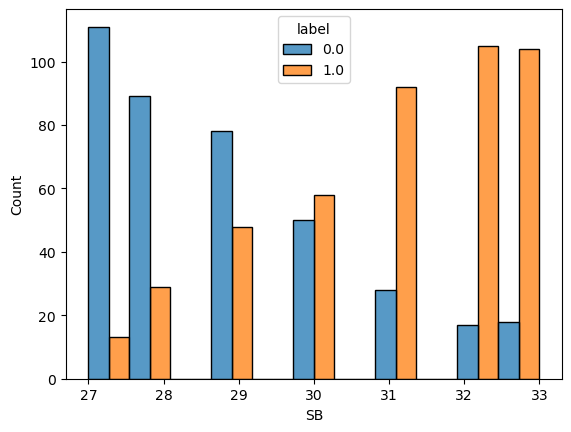

In [62]:
train2 = pd.read_csv(f"{path}Z0train.csv")
train2["SB"] = train2['brillo']
train2["label"] = train2["label"]
sns.histplot(data=train2,x="SB",hue="label", multiple="dodge")

In [64]:
#ttt = pd.DataFrame({'direccion':pd.concat([train['direccion'].str.split("/").str[7].str[:-5],train2['AU']]).reset_index(drop=True)}).reset_index(drop=True)
ttt = pd.DataFrame({'direccion':pd.concat([train['AU'],"/data/processing/avera/proyecto_deep/fits_rot/" + train2['AU'] + ".fits"]).reset_index(drop=True)}).reset_index(drop=True)
ttt['SB'] = pd.concat([train["SB"].apply(int),train2["SB"].apply(int)]).reset_index(drop=True)
ttt['label'] = pd.concat([train["label"].apply(int),train2["label"].apply(int)]).reset_index(drop=True)

<Axes: xlabel='SB', ylabel='Count'>

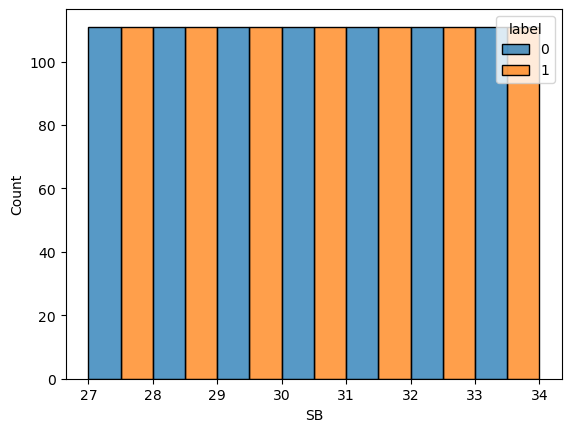

In [65]:
sns.histplot(data=ttt,x="SB",hue="label", multiple="dodge",bins=np.arange(27,35,1))

In [69]:
val = pd.read_csv(f"/{path}Z0val.csv")
test = pd.read_csv(f"/{path}Z0test.csv")
val["direccion"] = path +  "fits_rot/" +  val["AU"]+".fits"
test["direccion"] = path+  "fits_rot/" + test["AU"]+".fits"
test["image"] = test.parallel_apply(lambda row : abrir_fits(row["direccion"]), axis=1)
val["image"] = val.parallel_apply(lambda row : abrir_fits(row["direccion"]), axis=1)

In [67]:
val = pd.read_csv(f"/{path}zvar_dat_aug/val.csv")
test = pd.read_csv(f"/{path}zvar_dat_aug/test.csv")
val["direccion"] = path +  "fits_zvar2/" +  val["AU"]+".fits"
test["direccion"] = path+  "fits_zvar2/" + test["AU"]+".fits"
test["image"] = test.parallel_apply(lambda row : abrir_fits(row["direccion"]), axis=1)
val["image"] = val.parallel_apply(lambda row : abrir_fits(row["direccion"]), axis=1)

In [68]:
ttt["image"] = ttt.parallel_apply(lambda row : abrir_fits(row["direccion"]), axis=1)

In [70]:
ttt["label"] = ttt.label.astype("int")
val["label"] = val.label.astype("int")
test["label"] = test.label.astype("int")

In [71]:
x_train = np.empty((len(ttt),300, 300,3))
x_val = np.empty((len(val),300,300,3))
x_test = np.empty((len(test),300,300,3))

for i,ima in enumerate(ttt["image"]):
    img2 = np.zeros( ( np.array(ima).shape[0], np.array(ima).shape[1], 3 ) )
    img2[:,:,0] = ima # same value in each channel
    img2[:,:,1] = ima
    img2[:,:,2] = ima
    x_train[i] = img2

for i,ima in enumerate(val["image"]):
    img2 = np.zeros( ( np.array(ima).shape[0], np.array(ima).shape[1], 3 ) )
    img2[:,:,0] = ima # same value in each channel
    img2[:,:,1] = ima
    img2[:,:,2] = ima
    x_val[i] = img2
    
for i,ima in enumerate(test["image"]):
    img2 = np.zeros( ( np.array(ima).shape[0], np.array(ima).shape[1], 3 ) )
    img2[:,:,0] = ima # same value in each channel
    img2[:,:,1] = ima
    img2[:,:,2] = ima
    x_test[i] = img2

In [72]:
np.max(x_train),np.min(x_train)

(1.0, 0.0)

In [74]:
val.brillo.unique()

array([27., 28., 29., 30., 31., 32., 33.])

In [75]:
import h5py
with h5py.File("/data/processing/avera/proyecto_deep/z0_da/z0da.h5", 'w') as hdf:
    # Guardar set de entrenamiento
    hdf.create_dataset('x_train', data=x_train)
    hdf.create_dataset('train_labels', data=ttt.label)
    hdf.create_dataset('train_sb', data=ttt.SB)
    
    # Guardar set de validación
    hdf.create_dataset('x_val', data=x_val)
    hdf.create_dataset('val_labels', data=val.label)
    hdf.create_dataset('val_sb', data=val.brillo)
    
    # Guardar set de testeo
    hdf.create_dataset('x_test', data=x_test)
    hdf.create_dataset('test_labels', data=test.label)
    hdf.create_dataset('test_sb', data=test.brillo)
